In [1]:
%matplotlib inline
import os
import sys
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
from tqdm import tqdm
import pymaster as nmt
sys.path.append('../')
import matplotlib
import lenspyx

In [2]:
%load_ext autoreload
%autoreload 2
import processing as method

usage: ipykernel_launcher.py [-h] [-delens] inifile
ipykernel_launcher.py: error: unrecognized arguments: -f


Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Maps
Simulation uses /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Maps
Delensing LiteBIRD-SET1 with LiteBIRD-SET1
Template is constructed using LiteBIRD-SET1
Delensing uses QE: p_eb
Reading coupling matrix from /global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Pseudo/workspace/coupling_matrix_Nside512_fsky_0p8_beam_30_Apo_C1_Deg_10.fits


In [3]:
idx = 0 
elm_wf = method.of_fqe.ivfs.get_sim_emliklm(idx)

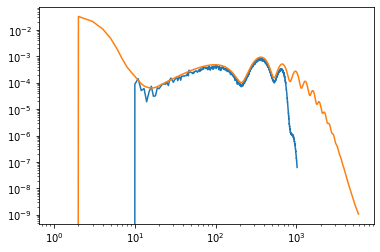

In [5]:
cl_ee = method.of_fqe.cl_len['ee']
plt.loglog(hp.alm2cl(elm_wf))
plt.loglog(np.arange(len(cl_ee)),cl_ee)

In [7]:
kappa_wf = method.delens_lib.kappa_wf(idx)
cl_pp = method.delens_lib.cl_ppf

In [10]:
q,u = lenspyx.alm2lenmap_spin([elm_wf, None], [kappa_wf, None], 2048, 2, facres=-1,)

BAND 0 in 8 :
resolve_poles: I have flipped 1 signs out of 2 pixels on north pole
resolve_poles: I have flipped 1 signs out of 2 pixels on south pole
input t1,t2 -0.306 11.608 in degrees
North 18.630 and South 18.656 buffers in amin
cell (theta,phi) in amin (1.866,1.061)
BAND 1 in 8 :
input t1,t2 10.877 22.865 in degrees
North 18.780 and South 18.745 buffers in amin
cell (theta,phi) in amin (1.878,1.025)
BAND 2 in 8 :
input t1,t2 22.122 34.134 in degrees
North 18.791 and South 18.818 buffers in amin
cell (theta,phi) in amin (1.882,1.480)
BAND 3 in 8 :
input t1,t2 33.388 45.374 in degrees
North 18.777 and South 18.759 buffers in amin
cell (theta,phi) in amin (1.878,0.938)
BAND 4 in 8 :
input t1,t2 44.610 56.643 in degrees
North 18.792 and South 18.851 buffers in amin
cell (theta,phi) in amin (1.885,1.101)
BAND 5 in 8 :
input t1,t2 55.881 67.867 in degrees
North 18.764 and South 18.776 buffers in amin
cell (theta,phi) in amin (1.878,1.221)
BAND 6 in 8 :
input t1,t2 67.128 79.112 in degre

In [4]:
q,u = method.delens_lib.get_template(0)

../delens.py:111: RuntimeWarning: invalid value encountered in true_divide
  fl = self.cl_ppf[ell]/(self.cl_ppf[ell]+(nhl[ell] * self.qnorm[ell] ** 2))


resolve_poles: I have flipped 1 signs out of 2 pixels on north pole
resolve_poles: I have flipped 1 signs out of 2 pixels on south pole


setting the output map dtype to [dtype('float64')]


Transfer function applied to the Template


setting the output map dtype to [dtype('float64')]


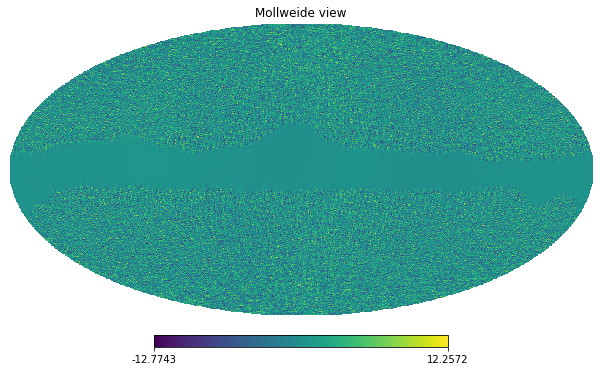

In [5]:
hp.mollview(q)

In [5]:
method.delens_lib.transf

True

In [3]:
mask = method.pseudocl_lib.mask
q,u = method.delens_lib.get_delensed_field(0)
#hp.read_map('/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside512_fsky_0p8_Apo_C1_Deg_10.fits',dtype=np.float64)
#maskf = hp.read_map('/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits.gz')
#mask_512 = hp.ud_grade(maskf,512)
#mask = nmt.mask_apodization(mask_512,8.0, apotype='C1')

In [4]:
b1 = nmt.NmtBin.from_nside_linear(512, 2)
b2 = nmt.NmtBin.from_nside_linear(512, 5)
b3 = nmt.NmtBin.from_nside_linear(512, 8)
b4 = nmt.NmtBin.from_nside_linear(512, 10)

In [12]:
beam = hp.gauss_beam(np.radians(30/60),lmax=(3*512)-1)

In [13]:
mask_wb = nmt.NmtField(mask, [mask, mask],purify_b=True,beam=beam)
mask_wob = nmt.NmtField(mask, [mask, mask],purify_b=True)

In [14]:
wb1 = nmt.NmtWorkspace()
wb1.compute_coupling_matrix(mask_wb, mask_wb, b1)

In [15]:
wb2 = nmt.NmtWorkspace()
wb2.compute_coupling_matrix(mask_wb, mask_wb, b2)

In [16]:
wb3 = nmt.NmtWorkspace()
wb3.compute_coupling_matrix(mask_wb, mask_wb, b3)

In [17]:
wb4 = nmt.NmtWorkspace()
wb4.compute_coupling_matrix(mask_wb, mask_wb, b4)

In [18]:
wob1 = nmt.NmtWorkspace()
wob1.compute_coupling_matrix(mask_wob, mask_wob, b1)

In [19]:
wob2 = nmt.NmtWorkspace()
wob2.compute_coupling_matrix(mask_wob, mask_wob, b2)

In [20]:
wob3 = nmt.NmtWorkspace()
wob3.compute_coupling_matrix(mask_wob, mask_wob, b3)

In [21]:
wob4 = nmt.NmtWorkspace()
wob4.compute_coupling_matrix(mask_wob, mask_wob, b4)

In [22]:
field_wb = nmt.NmtField(mask, [hp.ud_grade(q,512), hp.ud_grade(u,512)],purify_b=True,beam=beam)
field_wob = nmt.NmtField(mask, [hp.ud_grade(q,512), hp.ud_grade(u,512)],purify_b=True)

(10, 700)

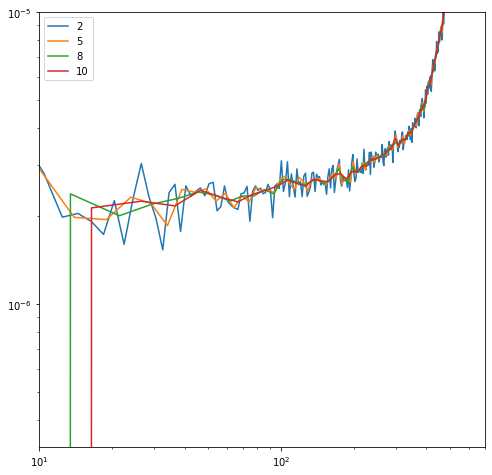

In [29]:
plt.figure(figsize=(8,8))
plt.loglog(b1.get_effective_ells(), wb1.decouple_cell(nmt.compute_coupled_cell(field_wb, field_wb))[3],label='2')
plt.loglog(b2.get_effective_ells(), wb2.decouple_cell(nmt.compute_coupled_cell(field_wb, field_wb))[3],label='5')
plt.loglog(b3.get_effective_ells(), wb3.decouple_cell(nmt.compute_coupled_cell(field_wb, field_wb))[3],label='8')
plt.loglog(b4.get_effective_ells(), wb4.decouple_cell(nmt.compute_coupled_cell(field_wb, field_wb))[3],label='10')
plt.legend()
plt.ylim(None,1e-5)
plt.xlim(10,700)

(10, 700)

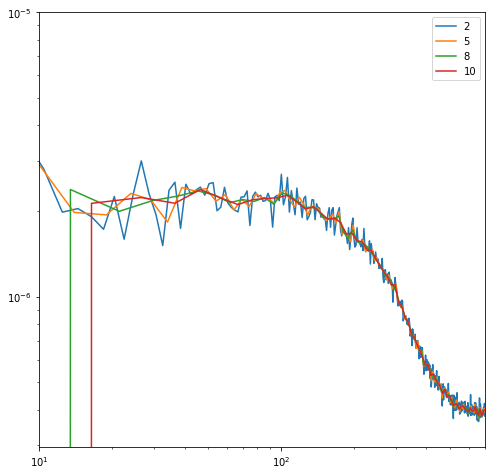

In [30]:
plt.figure(figsize=(8,8))
plt.loglog(b1.get_effective_ells(), wob1.decouple_cell(nmt.compute_coupled_cell(field_wob, field_wob))[3],label='2')
plt.loglog(b2.get_effective_ells(), wob2.decouple_cell(nmt.compute_coupled_cell(field_wob, field_wob))[3],label='5')
plt.loglog(b3.get_effective_ells(), wob3.decouple_cell(nmt.compute_coupled_cell(field_wob, field_wob))[3],label='8')
plt.loglog(b4.get_effective_ells(), wob4.decouple_cell(nmt.compute_coupled_cell(field_wob, field_wob))[3],label='10')
plt.legend()
plt.ylim(None,1e-5)
plt.xlim(10,700)

In [9]:
p_f = nmt.NmtField(mask, [hp.ud_grade(q,512), hp.ud_grade(u,512)],purify_b=True)

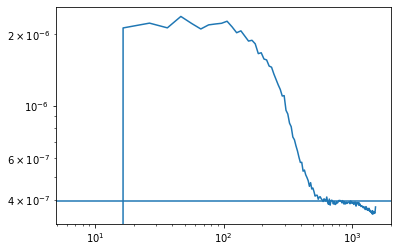

In [10]:
plt.loglog(b.get_effective_ells(), w.decouple_cell(nmt.compute_coupled_cell(p_f, p_f))[3])
plt.axhline(np.radians(2.16/60)**2)

In [32]:
type(method.pcl_beam)

int